
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Авторы материала: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 (демо)
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1qzcrfsNFy-e4TW59v2fqMj_OTom2SIOxtq4MWlI92p0).

In [331]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import adjusted_rand_score

RANDOM_STATE = 17

# если ошбика при запуске KMeans
# !pip install -U threadpoolctl

In [332]:
X_train = np.loadtxt("./../data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("./../data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("./../data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("./../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [333]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [334]:
# Ваш код здесь
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [13]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [336]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [337]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [338]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [339]:
pca.components_.shape[0]

65

**Варианты:**
- 56 
- 65
- 66
- 193

**Ответ:** 65

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [340]:
round(pca.explained_variance_ratio_[0], 2)

0.51

**Ответ:** 51

Визуализируйте данные в проекции на первые две главные компоненты.

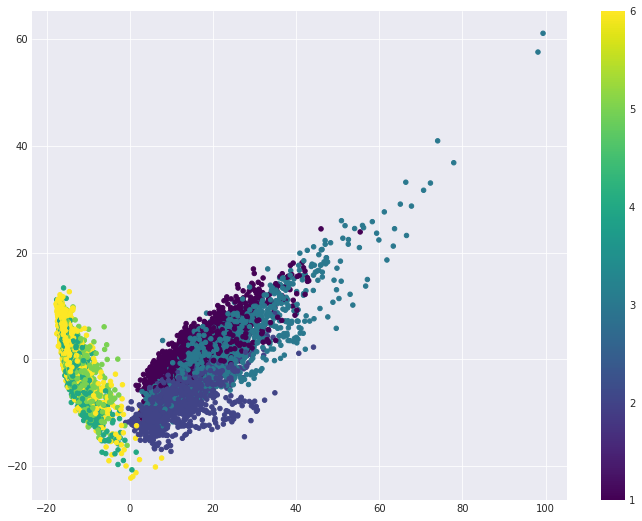

In [145]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.colorbar();

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

**Ответ:** 2 кластера

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [357]:
kmeans = KMeans(n_clusters=6,  n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca);

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

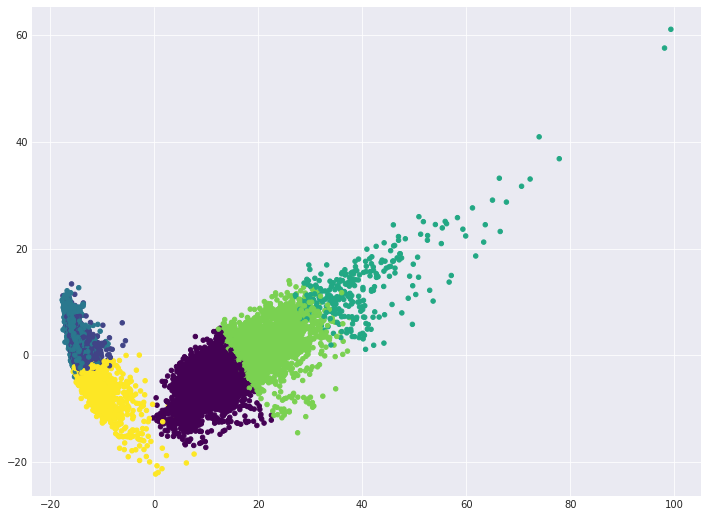

In [358]:
cluster_labels = kmeans.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [359]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем вверх по лестнице,1241,0,0,5,296,2,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,1235,91,0,0,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,5,52,1558,0,0,329,1944
все,2470,2631,1649,279,1927,1343,10299


In [360]:
vals = [(np.max(tab.T[column][:-1]), tab.T[column][-1]) for (i, column) in enumerate(tab.T.columns[:-1])]

print(f'Среднее значение метрики %.2f, лучшее значение у "%s" (%.2f), худшее значение у "%s" (%.2f)' % (
          np.mean([i[0]/i[1] for i in vals]), tab.T.columns[np.argmax([i[0]/i[1] for i in vals])],
          ([i[0]/i[1] for i in vals])[np.argmax([i[0]/i[1] for i in vals])],
          tab.T.columns[np.argmin([i[0]/i[1] for i in vals])],
          ([i[0]/i[1] for i in vals])[np.argmin([i[0]/i[1] for i in vals])])
     )     

Среднее значение метрики 0.69, лучшее значение у "подъем вверх по лестнице" (0.80), худшее значение у "ходьба" (0.52)


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

**Ответ:** перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]


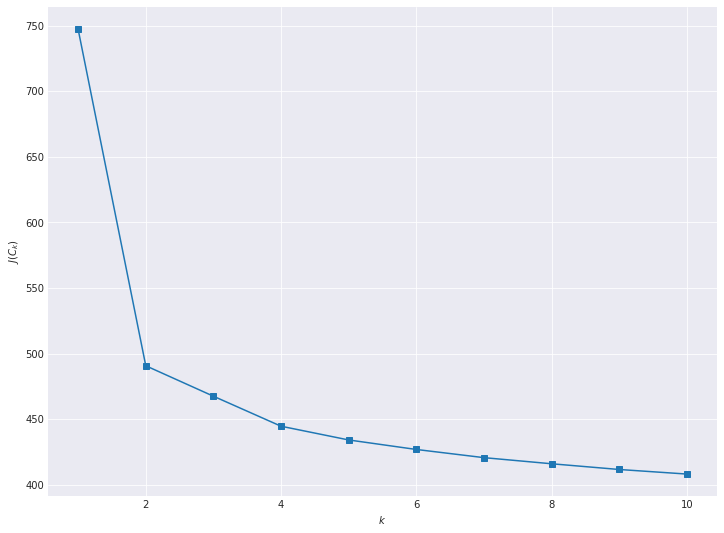

In [161]:
n_clusters = 10 
n_clusters = np.linspace(1, n_clusters, n_clusters).astype(int)

inertia = []
for k in tqdm(n_clusters):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(n_clusters, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [212]:
def count_elbow_rate(inertia):
    
    rate = [((inertia[i+1] - inertia[i]) / (inertia[i] - inertia[i-1]) ) 
     for i in range(1, len(inertia[1:-1]))]
    
    idx = 0
    min_rate = rate[idx]
    
    for i in range(1, len(rate)):
        if rate[i] <= min_rate:
            idx=i
            min_rate = rate[i]
        else:
            break
            
    return rate, min_rate, idx+1
    

In [213]:
rate, min_rate, min_rate_idx = count_elbow_rate(inertia)

Text(0.5, 0.98, 'Оптимальное число кластеров: 2')

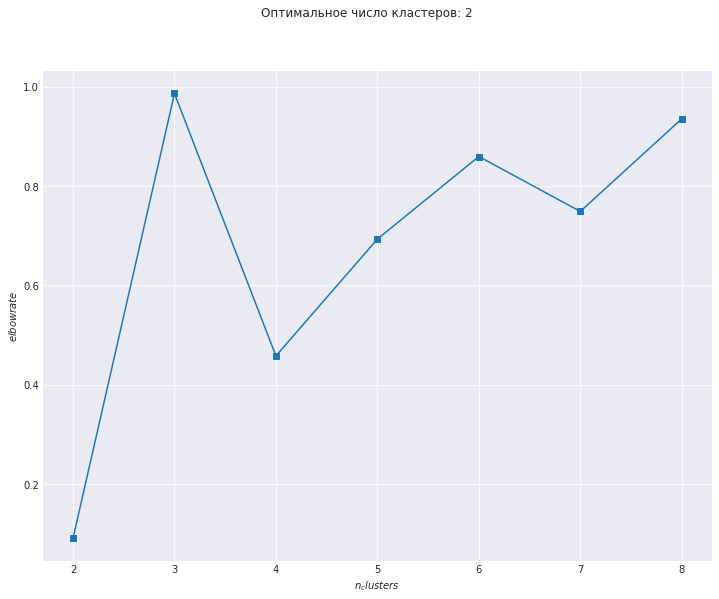

In [214]:
plt.plot(range(2, len(inertia[1:-1])+1), 
         rate, marker='s');
plt.xlabel('$n_clusters$')
plt.ylabel('$elbow rate$');
plt.suptitle('Оптимальное число кластеров: %s' % str(min_rate_idx+1))

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

**Ответ:** 2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [234]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [235]:
kmeans_ari_score = adjusted_rand_score(y, kmeans.labels_)
ag_ari_score = adjusted_rand_score(y, ag.labels_)

In [236]:
print("KMeans ARI: ",kmeans_ari_score)
print("Agglomerative Clustering ARI: ", ag_ari_score)

KMeans ARI:  0.4184648234768336
Agglomerative Clustering ARI:  0.49362763373004886


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

**Ответ:** 1, 2, 3

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [239]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [240]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [246]:
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
best_svc.fit(X_train_scaled, y_train);

In [247]:
best_svc.best_params_

{'C': 0.1}

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

**Ответ:** 0.1

In [248]:
y_predicted = best_svc.predict(X_test_scaled)

In [249]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,3,414,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,468,414,442,589,526,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

In [356]:
print('Хуже всего по точности: %s' %
    tab.T.columns[np.argmin([np.max(tab.values[i][:-1]) / tab.values[i][-1] for i in range(0, len(tab.values[:-1]))])])

print('Хуже всего по полноте: %s' %
    tab.T.columns[np.argmin([np.max(tab.values[i][:-1]) / tab.values[-1][i] for i in range(0, len(tab.values[:-1]))])])

Хуже всего по точности: сидение
Хуже всего по полноте: стояние


**Ответ:** по точности – сидение, по полноте – стояние

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

In [287]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca_train = pca.fit_transform(X_train_scaled)

In [290]:
X_pca_test = pca.transform(X_test_scaled)

In [300]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [303]:
best_svc_with_pca = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
best_svc_with_pca.fit(X_pca_train, y_train);

In [302]:
best_svc_with_pca.best_params_

{'C': 1}

In [330]:
print('Разница в доле верных ответов(в процентах): %.0f' 
      % (round(best_svc.best_score_ - best_svc_with_pca.best_score_, 2) * 100) )

Разница в доле верных ответов(в процентах): 4


**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


**Ответ:** 4%

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Ответ:** 2, 3